In [ ]:
# TotalSegmentator usage test

from totalsegmentator.python_api import totalsegmentator as ts

input_path = "ct.nii.gz"
output_path = "segmentations"

ts(input_path, output_path)

In [ ]:
from totalsegmentator.python_api import totalsegmentator as ts

indir = "./data/nifti/";
outdir = "./segmentations/";

main = sitk.ReadImage("ct.nii.gz", outputPixelType = sitk.sitkInt32)

for file in os.listdir(indir):
    if os.path.isfile(indir + file) and ".nii.gz" in file:
        
        path = outdir + file.replace(".nii.gz", "")
        
        if not os.path.exists(path):
            os.makedirs(path)
        
        print(indir + file)
        
        ts(indir + file, path)

In [2]:
filenames = ["Angio_z_powrotem_Flash_20211129105819_6", 
             "Flash_ANGIO_AORTA_20200224084444_4",
             "Przed_i_Angio_z_powrotem_Flash_20221215091334_6",
             "Przed_i_Angio_z_powrotem_Flash_20221215091334_7",
             "TETNICE_WIENCOWE_20221010115446_4",
             "test"]

current = 0

In [14]:
# Process and format segmented files for visualization

import SimpleITK as sitk
import os

for subdir in filenames:
    print(subdir)

    maindir = "./data/nifti/" + subdir + ".nii.gz"
    indir = "./segmentations/" + subdir + "/";
    outdir = "./segmentations/" + subdir + "/mhd/";

    main = sitk.ReadImage(maindir, outputPixelType = sitk.sitkInt32)

    if not os.path.exists(outdir):
        os.makedirs(outdir)

    for file in os.listdir(indir):
        if os.path.isfile(indir + file) and ".nii.gz" in file :
            print(file)

            img = sitk.ReadImage(indir + file, outputPixelType = sitk.sitkInt32)

            path = outdir + file.replace(".nii.gz", ".mhd")
            mask_filter = sitk.MultiplyImageFilter()
            res = mask_filter.Execute(main, img)

            minmax_filter = sitk.MinimumMaximumImageFilter()
            minmax_filter.Execute(img)

            if minmax_filter.GetMaximum() != 0 :
                sitk.WriteImage(res, path)

0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0


In [ ]:
# More lightweight solution for just the layer mask

import SimpleITK as sitk
import os

for subdir in filenames:
    print(subdir)
    
    indir = "./segmentations/" + subdir + "/";
    outdir = "./segmentations/" + subdir + "/mhd/";

    if not os.path.exists(outdir) :
        os.makedirs(outdir)

    for file in os.listdir(indir):
        if os.path.isfile(indir + file) and ".nii.gz" in file :
            print(file)

            img = sitk.ReadImage(indir + file, outputPixelType = sitk.sitkUInt8)

            path = outdir + file.replace(".nii.gz", ".mhd")
            scale_filter = sitk.ShiftScaleImageFilter()
            scale_filter.SetScale(100)
            res = scale_filter.Execute(img)

            minmax_filter = sitk.MinimumMaximumImageFilter()
            minmax_filter.Execute(img)

            if minmax_filter.GetMaximum() != 0 :
                sitk.WriteImage(res, path)

In [29]:
import SimpleITK as sitk
import os

indir = "./data/nifti/";
outdir = "./data/mhd/";

if not os.path.exists(outdir):
    os.makedirs(outdir)
    
for file in os.listdir(indir):
    if os.path.isfile(indir + file) and ".nii.gz" in file :
        img = sitk.ReadImage(indir + file, outputPixelType = sitk.sitkUInt8)
        
        minmax_filter = sitk.MinimumMaximumImageFilter()
        minmax_filter.Execute(img)
        
        print(minmax_filter.GetMaximum());
        print(minmax_filter.GetMinimum());
        
        path = outdir + file.replace(".nii.gz", ".mhd")
        
        print(path)
        
        sitk.WriteImage(img, path)

255.0
0.0
./data/mhd/Angio_z_powrotem_Flash_20211129105819_6.mhd
255.0
0.0
./data/mhd/Flash_ANGIO_AORTA_20200224084444_4.mhd
255.0
0.0
./data/mhd/Przed_i_Angio_z_powrotem_Flash_20221215091334_6.mhd
255.0
0.0
./data/mhd/Przed_i_Angio_z_powrotem_Flash_20221215091334_7.mhd
255.0
0.0
./data/mhd/test.mhd
255.0
0.0
./data/mhd/TETNICE_WIENCOWE_20221010115446_4.mhd


In [ ]:
# Create MIP renderer

import platform
if platform.system() != 'Windows':
    import PySide2.QtSvg # Must import this before fast due to conflicting symbols
import fast # Must import FAST before rest of pyside2
from PySide2.QtWidgets import *
from PySide2.QtCore import Qt
from shiboken2 import wrapInstance
import random as rd
import functools
import keyboard
import os

subdir = filenames[current]
indir = "./segmentations/" + subdir + "/mhd/aorta.mhd";

# Create FAST Pipeline and window
window = fast.SimpleWindow3D.create(width=1024, height=512)\

importer = fast.ImageFileImporter.create(indir)
renderer = fast.MaximumIntensityProjection.create()
renderer.connect(importer)
window.connect(renderer)

print(filenames[current])

# Run everything!
window.run()

In [ ]:
# Create volume renderer

import platform
if platform.system() != 'Windows':
    import PySide2.QtSvg # Must import this before fast due to conflicting symbols
import fast # Must import FAST before rest of pyside2
from PySide2.QtWidgets import *
from PySide2.QtCore import Qt
from shiboken2 import wrapInstance
import random as rd
import functools
import keyboard
import os

# Create FAST Pipeline and window
window = fast.SimpleWindow3D.create(width=1024, height=512)\

importer = fast.ImageFileImporter.create("ct.mhd")
renderer = fast.AlphaBlendingVolumeRenderer.create()
renderer.connect(importer)
window.connect(renderer)


# Run everything!
window.run()

In [ ]:
# Create visualizer

import platform
if platform.system() != 'Windows':
    import PySide2.QtSvg # Must import this before fast due to conflicting symbols
import fast # Must import FAST before rest of pyside2
from PySide2.QtWidgets import *
from PySide2.QtCore import Qt
from shiboken2 import wrapInstance
import random as rd
import functools
import keyboard
import os

subdir = filenames[current]
segdir = "./segmentations/" + subdir + "/mhd/";

renderers = []
active = []

def import_segment(x) :
    print(x)
    
    importer = fast.ImageFileImporter.create(segdir + x)

    extraction = fast.SurfaceExtraction\
            .create(threshold=50)\
            .connect(importer)

    r = rd.uniform(0.5, 1);
    g = rd.uniform(0.5, 1);
    b = rd.uniform(0.5, 1);

    mesh = extraction.runAndGetOutputData()

    renderer = fast.TriangleRenderer\
            .create(color=fast.Color(r, g, b))\
            .connect(mesh)
    
    renderers.append(renderer)
    active.append(True)

    window.connect(renderer)
    
def toggle_segment_alpha(i):
    print(i)
    window.removeAllRenderers()
    window.connect(renderers[i])
    active[i] = True
    renderers[i].setOpacity(0, 1)
    
    changed = []
    
    for j in range(0, len(renderers)):
        if i != j and active[j]:
            window.connect(renderers[j])
            if not keyboard.is_pressed('q'):
                active[j] = False
                renderers[j].setOpacity(0, 0.05) 
                changed.append(j)
    
    for j in range(0, len(renderers)):
        if i != j and not active[j] and j not in changed:
            window.connect(renderers[j])
            renderers[j].setOpacity(0, 0.05)    
            
def reset_segment_alpha():
    for j in range(0, len(renderers)):
        renderers[j].setOpacity(0, 1)
        active[j] = True
            
    
def toggle_segment(i):
    return lambda: toggle_segment_alpha(i)

def export_mesh():
    return 0

# Create FAST Pipeline and window
window = fast.SimpleWindow3D.create(width=1024, height=512)\

# Get the underlying QtWidget of the FAST window and convert it to pyside2
mainWidget = wrapInstance(int(window.getWidget()), QWidget)

# Create GUI in Qt
layout = mainWidget.layout()
menuWidget = QWidget()
layout.addWidget(menuWidget)
menuLayout = QVBoxLayout()
menuWidget.setLayout(menuLayout)
menuLayout.setAlignment(Qt.AlignTop)
menuWidget.setFixedWidth(400)

# Create segment list
widget = QWidget()   

seglist = QVBoxLayout()
seglist.setAlignment(Qt.AlignTop)

scroll = QScrollArea()
scroll.setVerticalScrollBarPolicy(Qt.ScrollBarAlwaysOn)
scroll.setHorizontalScrollBarPolicy(Qt.ScrollBarAlwaysOff)
scroll.setWidgetResizable(True)

files = os.listdir(segdir)

idx = 0

for i in range(0, len(files)) :
    if os.path.isfile(segdir + files[i]) and ".mhd" in files[i] :
        elem_button = QPushButton(files[i][:-4])
        elem_button.clicked.connect(toggle_segment(idx))
        import_segment(files[i])
        seglist.addWidget(elem_button)
        idx += 1
        
widget.setLayout(seglist)
scroll.setWidget(widget)
        
reset = QPushButton("Reset view")
reset.clicked.connect(lambda: reset_segment_alpha())
    
menuLayout.addWidget(reset)
menuLayout.addWidget(scroll)

reset = QPushButton(files[i][:-4])
        
# Run everything!
window.run()

In [ ]:
from stl import mesh as stmesh
import math
import numpy as np
import fast

indir = "./segmentations/test/mhd/";
outdir = "./meshes/";
# Spine
#files = [\
#    "vertebrae_L1",\
#    "vertebrae_L2",\
#    "vertebrae_L3",\
#    "vertebrae_L4",\
#    "vertebrae_L5",\
#    "vertebrae_T1",\
#    "vertebrae_T10",\
#    "vertebrae_T11",\
#    "vertebrae_T12",\
#    "vertebrae_T2",\
#    "vertebrae_T3",\
#    "vertebrae_T4",\
#    "vertebrae_T5",\
#    "vertebrae_T6",\
#    "vertebrae_T7",\
#    "vertebrae_T8",\
#    "vertebrae_T9",\
#    "sacrum"];

# Heart
files = [\
    "heart_atrium_left",\
    "heart_atrium_right",\
    "heart_myocardium",\
    "heart_ventricle_left",\
    "heart_ventricle_right"];

verts = []
faces = []

offset = 0

for file in files:
    importer = fast.ImageFileImporter.create(indir + file + ".mhd")
    smoothing = fast.GaussianSmoothing.create(stdDev=2.0).connect(importer)
    extraction = fast.SurfaceExtraction.create(threshold=50).connect(smoothing)
    mesh = extraction.runAndGetOutputData()
    access = mesh.getMeshAccess(fast.ACCESS_READ)

    for vertex in access.getVertices():
        verts.append(vertex.getPosition().reshape(1, 3))

    for face in access.getTriangles():
        faces.append([offset + face.getEndpoint1(), offset + face.getEndpoint2(), offset + face.getEndpoint3()])
        
    offset = len(verts)
    
    print(file)
    
verts = np.array(verts)
faces = np.array(faces)
    
model = stmesh.Mesh(np.zeros(faces.shape[0], dtype=stmesh.Mesh.dtype))
for i, f in enumerate(faces):
    for j in range(3):
        model.vectors[i][j] = verts[f[j],:]
    
model.save(outdir + "output.stl")

In [ ]:
from vmtk import pypes
from vmtk import vmtkscripts

args = "vmtkimagereader -ifile ./ct.mhd --pipe vmtkimagewriter -ofile ./ct.vti"

res = pypes.PypeRun(args)

In [ ]:
# Example marching cubes surface extraction without level set meshing from segmented file

from vmtk import pypes
from vmtk import vmtkscripts

args = "vmtkimagereader -ifile ./segmentations/test/vti/aorta.vti --pipe\
        vmtkmarchingcubes -l 80.0 -ofile ./meshes/vtp/aorta.vtp --pipe\
        vmtkrenderer --pipe vmtkimageviewer --pipe vmtksurfaceviewer"

res = pypes.PypeRun(args)

In [ ]:
# Segmenting the aorta via levelsets

from vmtk import pypes
from vmtk import vmtkscripts

args = "vmtklevelsetsegmentation -ifile ./segmentations/test/vti/aorta.vti --pipe vmtkmarchingcubes -i @.o -ofile ./meshes/vtp/aorta.vtp"

pypes.PypeRun(args)

In [ ]:
# Clipping mesh inlets and outlets
  
from vmtk import pypes
from vmtk import vmtkscripts

args = "vmtksurfaceclipper -ifile ./meshes/vtp/aorta.vtp -ofile ./meshes/vtp/aorta_clip.vtp"

res = pypes.PypeRun(args)

In [ ]:
# Surface subdivision

from vmtk import pypes
from vmtk import vmtkscripts

args = "vmtksurfacesubdivision -ifile ./meshes/vtp/aorta_smooth.vtp -ofile ./meshes/vtp/aorta_subdiv.vtp -method butterfly"

res = pypes.PypeRun(args)

In [ ]:
# Surface smoothing

from vmtk import pypes
from vmtk import vmtkscripts

args = "vmtksurfacesmoothing -ifile ./meshes/vtp/aorta_clip.vtp -passband 0.1 -iterations 30 -ofile ./meshes/vtp/aorta_smooth.vtp "

res = pypes.PypeRun(args)

In [ ]:
# Comparison

from vmtk import pypes
from vmtk import vmtkscripts

args = "vmtksurfacereader -ifile ./meshes/vtp/aorta_clip.vtp --pipe vmtksurfacesmoothing -iterations 30 -passband 0.1 --pipe vmtkrenderer --pipe vmtksurfaceviewer -display 0 --pipe vmtksurfaceviewer -i @vmtksurfacereader.o -color 1 0 0 -display 1"

res = pypes.PypeRun(args)

In [ ]:
# Centerline computation

from vmtk import pypes
from vmtk import vmtkscripts

args = "vmtkcenterlines -ifile ./meshes/vtp/aorta_smooth.vtp -ofile ./meshes/vtp/aorta_centerline.vtp"

res = pypes.PypeRun(args)

In [ ]:
# Centerline computation visualization

from vmtk import pypes
from vmtk import vmtkscripts

args = "vmtksurfacereader -ifile ./meshes/vtp/aorta_smooth.vtp --pipe vmtkcenterlines --pipe vmtkrenderer --pipe vmtksurfaceviewer -opacity 0.25 --pipe vmtksurfaceviewer -i @vmtkcenterlines.o -array MaximumInscribedSphereRadius"

res = pypes.PypeRun(args)

In [ ]:
# Centerline computation visualization

from vmtk import pypes
from vmtk import vmtkscripts

args = "vmtksurfacereader -ifile ./meshes/vtp/aorta_smooth.vtp --pipe vmtkcenterlines --pipe vmtkrenderer --pipe vmtksurfaceviewer -opacity 0.25 --pipe vmtksurfaceviewer -i @vmtkcenterlines.voronoidiagram -array MaximumInscribedSphereRadius --pipe vmtksurfaceviewer -i @vmtkcenterlines.o"

res = pypes.PypeRun(args)

In [ ]:
# Prepare centerline for Gmsh meshing

from vmtk import pypes
from vmtk import vmtkscripts

args = "vmtksurfacewriter -ifile ./meshes/vtp/aorta_centerline.vtp -ofile ./meshes/vtp/aorta_centerline.vtk"

res = pypes.PypeRun(args)

In [4]:
import SimpleITK as sitk

def np_read(file) :
    img = sitk.ReadImage(file)
    array = sitk.GetArrayFromImage(img)
    return array;

In [5]:
# Alternative voxel-based centerline extraction

import SimpleITK as sitk
import os
import numpy as np
import time
from scipy.ndimage import binary_erosion
from skimage.morphology import skeletonize

file = "./segmentations/" + filenames[1] + "/mhd/trachea.mhd"
    
array = np_read(file)     
    
start = time.perf_counter()

sk = skeletonize(array)
    
end = time.perf_counter()

centerline = np.where(sk != 0)

print(end - start)

10.954251099999965


<IPython.core.display.Javascript object>


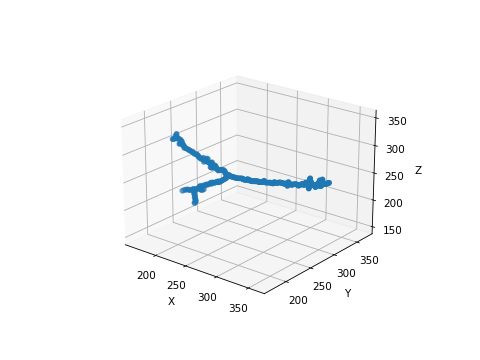

In [6]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

xs = centerline[0];
ys = centerline[1];
zs = centerline[2];

max_range = np.array([xs.max()-xs.min(), ys.max()-ys.min(), zs.max()-zs.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(xs.max()+xs.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(ys.max()+ys.min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(zs.max()+zs.min())
# Comment or uncomment following both lines to test the fake bounding box:
for xb, yb, zb in zip(Xb, Yb, Zb):
   ax.plot([xb], [yb], [zb], 'w')

ax.scatter(xs, ys, zs)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

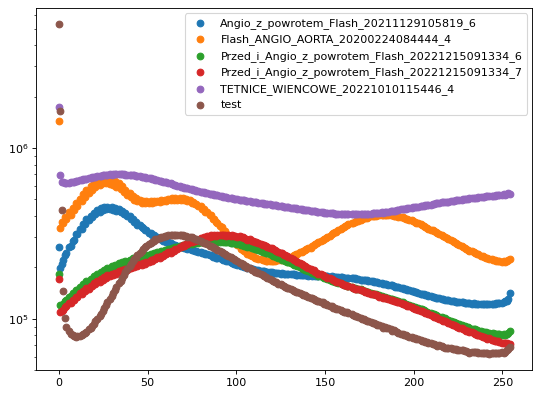

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

plt.yscale('log')

for i in range(0, 6):
    file = "./data/mhd/" + filenames[i] + ".mhd"
    array = np_read(file);
    flat = array.flatten();
    counts, bins = np.histogram(flat, bins=300, density=None, weights=None);
    plt.scatter(bins[:-1], counts, label=filenames[i])

plt.legend()
plt.show()